# Object Detection - SSD - fastai 2.7.8

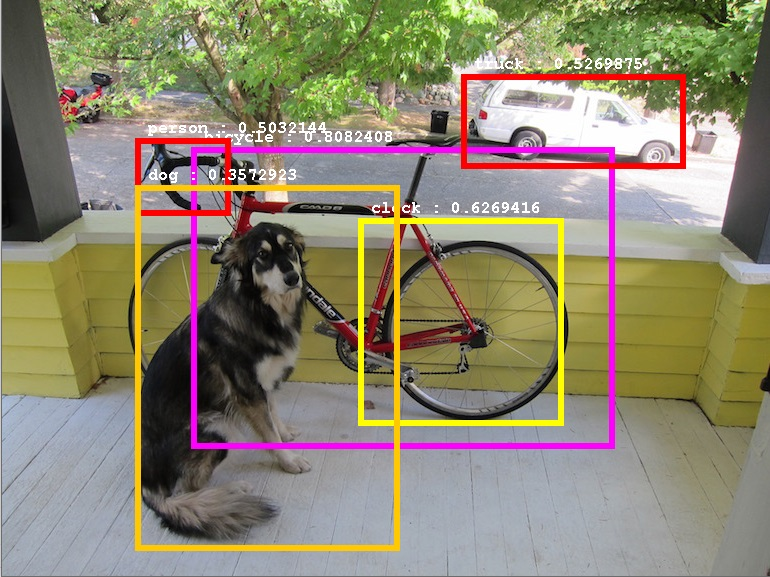

Src: https://blog.jetbrains.com/kotlin/2022/01/object-detection-with-kotlindl-and-ktor/

Recently, I have an idea of making a simple variation of Object Detection Architecture. However, when I searched for related repositories, I found it quite difficult to modify the existing architecture. We have a lot of libraries for using out of the box but hard to make change on the source code.

This blog is the implementation of Single Shot Detector Architecture using fast.ai in `literate programming` style so the readers can follow and litterally run each line of code themselves in case needed

Original idea taken from fastai 2018 course. Readers is recommended to watch this lecture. https://course18.fast.ai/lessons/lesson9.html

Some useful notes taken by students:
- https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-9-multi-object-detection.md
- https://francescopochetti.com/fast-ai-dl2-lesson-9-single-shot-detection-detailed-walkthrough/

Dataset used: Pascal 2017

What we can learn from this notebook:

- Object Detection DataLoaders from fastai `DataBlock` which contains Image, Bounding Box and Label. Understanding how the data resemble
- Building Single Shot Detector (SSD) - Object Detection Model
- Simple 4x4 Anchor Boxes. Relation between Receptive field and Anchor Boxes. 
- Loss function, Visualize Match to Ground-Truth
- Classificaton Loss Discussion: Binary Cross Entropy and why Focal Loss is better 
- More Anchor Boxes: 3 layers of grids ( 4x4, 2x2, 1x1 ) with 9 variations (Zoom,Scale) / cell
- Training and Results
- Cleaning predictions with Non Maximum Supression (NMS)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *

## Object Detection Dataloaders

For objection detection, you have:

- 1 independent variable (X): Image
- 2 dependents variables (Ys): Bounding box and Class  

In this part we will use fastai `DataBlock` to build Object Detection `Dataloaders`. The idea is from each image file name, we will have:

- An Image
- Bounding Boxes getting from the annotations file and rescale to -1 -> 1
- Labels correspond to each bounding box 


!! Notes:
- Padding: Because each image can have different number of objects, to make it possible gathering to one batch, the number of bounding boxes is the maximum in that batch (the padding value by default is 0) https://docs.fast.ai/vision.data.html#bb_pad
- Background class: In Object Detection, we need to have a class for background. `fastai` do it automatically for you by adding `#na#` at position 0
- The coordinates of bounding box is rescaled to ~ -1 -> 1 in `fastai/vision/core.py` _scale_pnts

( Check out some outputs below for details )

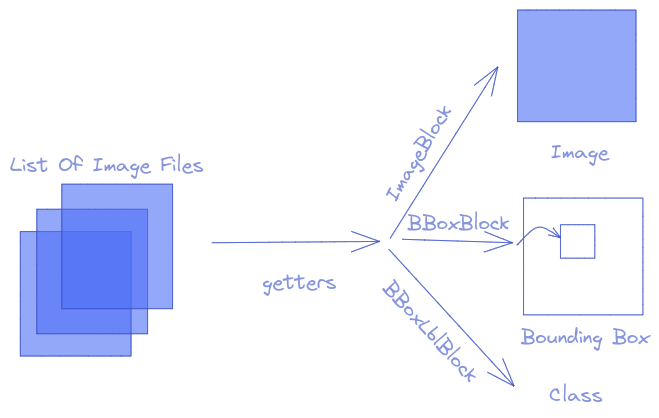

In [3]:
path = untar_data(URLs.PASCAL_2007)

In [4]:
path.ls()

(#8) [Path('/home/ubuntu/.fastai/data/pascal_2007/train.json'),Path('/home/ubuntu/.fastai/data/pascal_2007/test.json'),Path('/home/ubuntu/.fastai/data/pascal_2007/test'),Path('/home/ubuntu/.fastai/data/pascal_2007/train.csv'),Path('/home/ubuntu/.fastai/data/pascal_2007/segmentation'),Path('/home/ubuntu/.fastai/data/pascal_2007/valid.json'),Path('/home/ubuntu/.fastai/data/pascal_2007/train'),Path('/home/ubuntu/.fastai/data/pascal_2007/test.csv')]

In [5]:
imgs, lbl_bbox = get_annotations(path/'train.json') 

In [6]:
imgs[0], lbl_bbox[0]

('000012.jpg', ([[155, 96, 351, 270]], ['car']))

In [7]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [8]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'000012.jpg': ([[155, 96, 351, 270]], ['car'])}

In [9]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

In [10]:
item_tfms = [Resize(224, method='squish'),]
batch_tfms = [Rotate(), Flip(), Dihedral()]

In [11]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [12]:
dls = pascal.dataloaders(imgs, bs = 128)

In [13]:
# #na# is background class as defined in BBoxLblBlock
dls.vocab

['#na#', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [14]:
len(dls.vocab)

21

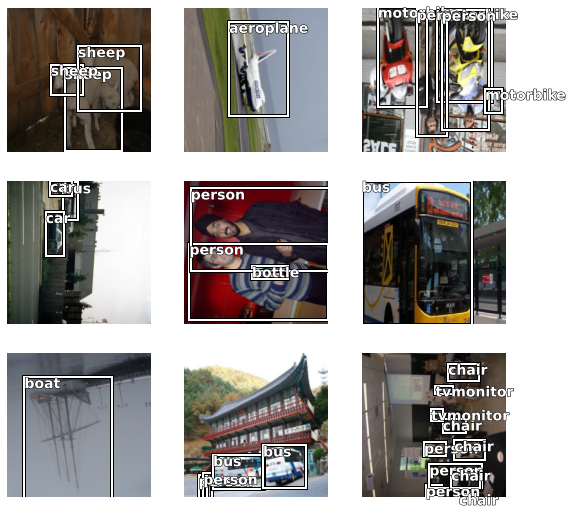

In [15]:
dls.show_batch()

In [16]:
one_batch = dls.one_batch()

In [17]:
# The coordinates of boudning box is rescaled to ~ -1 -> 1 in `fastai/vision/core.py` 
one_batch[1][0][0]

TensorBBox([ 0.3040, -0.9893,  1.0000, -0.0347], device='cuda:0')

In [18]:
# Zero Padding
one_batch[2]

TensorMultiCategory([[ 6,  6, 15,  ...,  0,  0,  0],
        [15, 15,  7,  ...,  0,  0,  0],
        [13, 15, 13,  ...,  0,  0,  0],
        ...,
        [15,  9,  9,  ...,  0,  0,  0],
        [12, 15, 15,  ...,  0,  0,  0],
        [20, 15, 15,  ...,  0,  0,  0]], device='cuda:0')

## Model Architecture

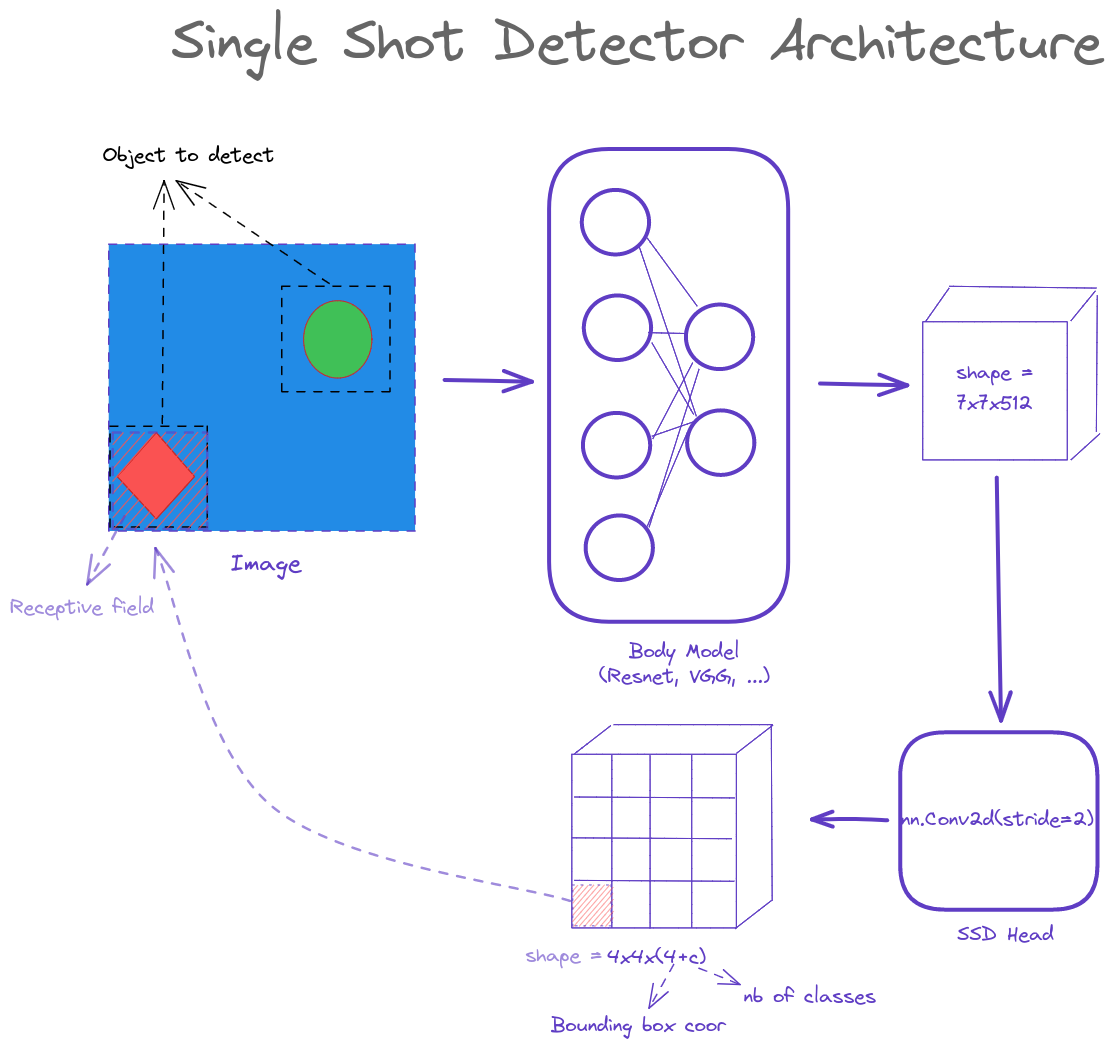

In a nutshell, Object Detection Model is a model that do 2 jobs at the same time: 

- a regressor with 4 outputs for bounding boxes
- a classifier with `c` classes. 

To handle multiple objects, here come the grid cell. For each cell, you will have an atomic prediction for the object that dominate a part of the image ( This is the idea of receptive field that you will see in the next part ) 

!! My Intuition: In Machine Learning, it is better improving from something rather than starting from scratch. You can see this in: Image Classification Architecture - Resnet with the `Skip Connections`, or Gradient Boosting in Tree based Model. There is a common point in the grid-cell SSD architecture, the model will try to improve from an `anchor box` rather than searching through the whole image.

We should better leverage a well-known pretrained classfication model to be uses as a backbone / or body ( resnet in this tutorial ) if the object is similar the Imagenet dataset. The head part will follow to adapt to the necessary dimension

To easily develop the idea - visualize and debug, we will start with a simple 4x4 grid

In [19]:
def flatten_conv(x,k):
    # Flatten the 4x4 grid to dim16 vectors
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [20]:
class OutConv(nn.Module):
    # Output Layers for SSD-Head. Contains oconv1 for Classification and oconv2 for Detection
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(dls.vocab))*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [21]:
class StdConv(nn.Module):
    # Standard Convolutional layers 
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [22]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)

We start with k = 1 which is the number of alterations for each anchor box ( we have a lot of anchor boxes later ) 

In [23]:
k=1

In [24]:
head_reg4 = SSD_Head(k, -3.)

In [25]:
body = create_body(resnet34(True))
model = nn.Sequential(body, head_reg4)

To understand and verify that everything works ok, you can take out a batch and run the model on it

In [26]:
out0 = body(one_batch[0].cpu())

In [27]:
out1 = head_reg4(out0)

In [28]:
out1[0].shape, out1[1].shape

(torch.Size([128, 16, 21]), torch.Size([128, 16, 4]))

Shape explanation:
- 128: batch size
- 16: number of anchor boxes
- 21: number of classes
- 4: number of bounding box coordinates

## 4x4 Anchor boxes and Receptive Field

As mentionned before, we will start with a 4x4 grid to better visualize the idea. The size will be normalized to [0,1]

The idea of why, after the Body, we use Conv2d and not Linear Layer to make a 4x4x(4+c) output dimension instead of 16x(4+c) shape is - Receptive Field. This way, each cell will have information that come directly from the location corresponding to the anchor box. Illustration as below. 

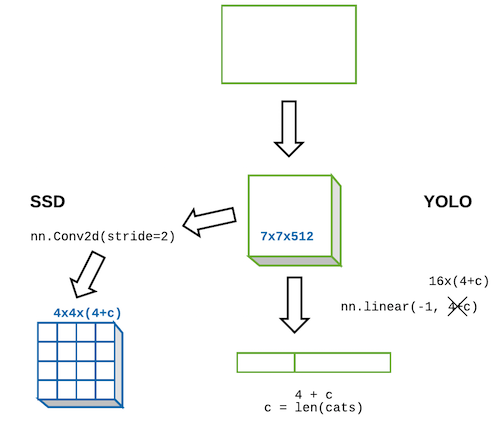

Source: https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-9-5f0cf9e4bb5b

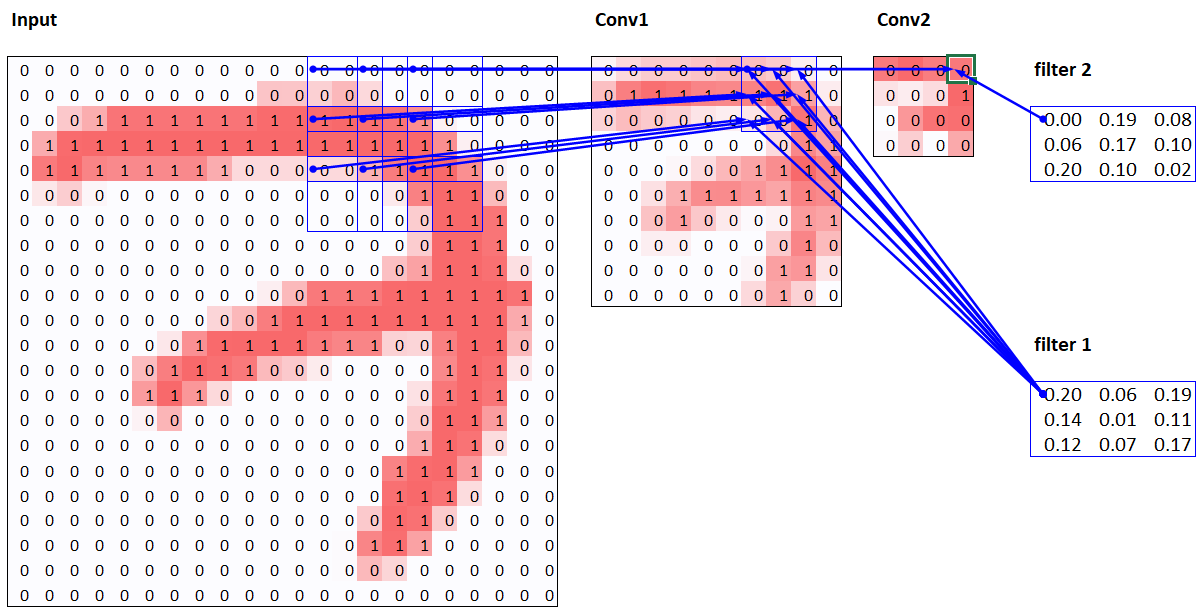

Src: https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb

!! Note: Be very careful about the bounding box format when working with Object Detection. There are many different formats out there. For example:

- pascal_voc: [x_min, y_min, x_max, y_max]
- coco: [x_min, y_min, width, height]
- yolo: [x_center, y_center, width, height]

The bounding box format in this tutorial is [x_min, y_min, x_max, y_max]

Check out this for more details: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

We define the anchors coordinates as below

In [29]:
anc_grid = 4 # Start with only 4x4 grid and no variation for each cell
k = 1 # Variation of each anchor box
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid) # Center of anc in x
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid) # Center f anc in y

In [30]:
anc_x

array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625,
       0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875])

In [31]:
anc_y

array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125,
       0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875])

In [32]:
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1)) # Anchor centers
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

In [33]:
anc_ctrs

array([[0.125, 0.125],
       [0.125, 0.375],
       [0.125, 0.625],
       [0.125, 0.875],
       [0.375, 0.125],
       [0.375, 0.375],
       [0.375, 0.625],
       [0.375, 0.875],
       [0.625, 0.125],
       [0.625, 0.375],
       [0.625, 0.625],
       [0.625, 0.875],
       [0.875, 0.125],
       [0.875, 0.375],
       [0.875, 0.625],
       [0.875, 0.875]])

In [34]:
anc_sizes

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

In [35]:
anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).cuda()
# Coordinates with format: center_x, center_y, W, H

In [36]:
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64)

In [37]:
grid_sizes = torch.tensor(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1).cuda()

In [38]:
grid_sizes

tensor([[0.2500]], device='cuda:0', dtype=torch.float64)

## Visualization Utils

It is very helpful (to understand/ debug) when you can visualize data of every steps. There are many subtle tiny details that happen in this Object Detection Problem. One careless implementation can lead to hours (or even days) to debug. Sometimes, you just wish that the code throw to you some bugs that you can track back. 

!! Notes: There are some details that you need to double check

- Are your ground truth bounding boxes, anchor boxes, bounding box activations are in the same scale ( -1 -> 1 or 0 -> 1 ) ?
- Do the background class is handled correctly? ( This is actual a bug when I develop this notebook that the old version of fastai course set the index of background is `number_of_classes` but in the latest version, it is 0 )
- Do you map correctly each Anchor Box to the grouth true object? (This will be shown in the next session)

!! Notes: Don't hesitate to take out one batch from your dataloader and verify every single details. When I start to use fast.ai, I made a big mistake that thinking these data are already processed and we can not show things directly from there. These data is very important, it is the input of your model. It must be carefully double check.

Below we will try to plot some images from a batch with their bounding boxes and classes, to see that we did not missing anything 

In [39]:
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects

In [40]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

In [41]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [42]:
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [43]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [44]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [45]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

In [46]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [47]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    k=0
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>1) and (pr is None or pr > thresh)):
            k+=1
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{k}: '
            if c is not None: txt += ('bg' if c==0 else dls.vocab[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [48]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

### Showing one batch

In [49]:
idx = 5

In [50]:
img = one_batch[0][idx].permute(2,1,0).cpu()

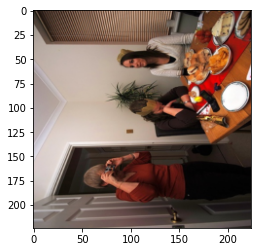

In [51]:
plt.imshow(img)

Extracting one batch for your dataloader and see if the data is OK 

In [52]:
x = one_batch[0].permute(0,3,2,1).cpu()

In [53]:
y = one_batch[1:]

Because the bounding box in dataloader is scaled to -1 -> 1, it need to be rescale to 0 -> 1 for drawing by doing (bb+1)/2*Size

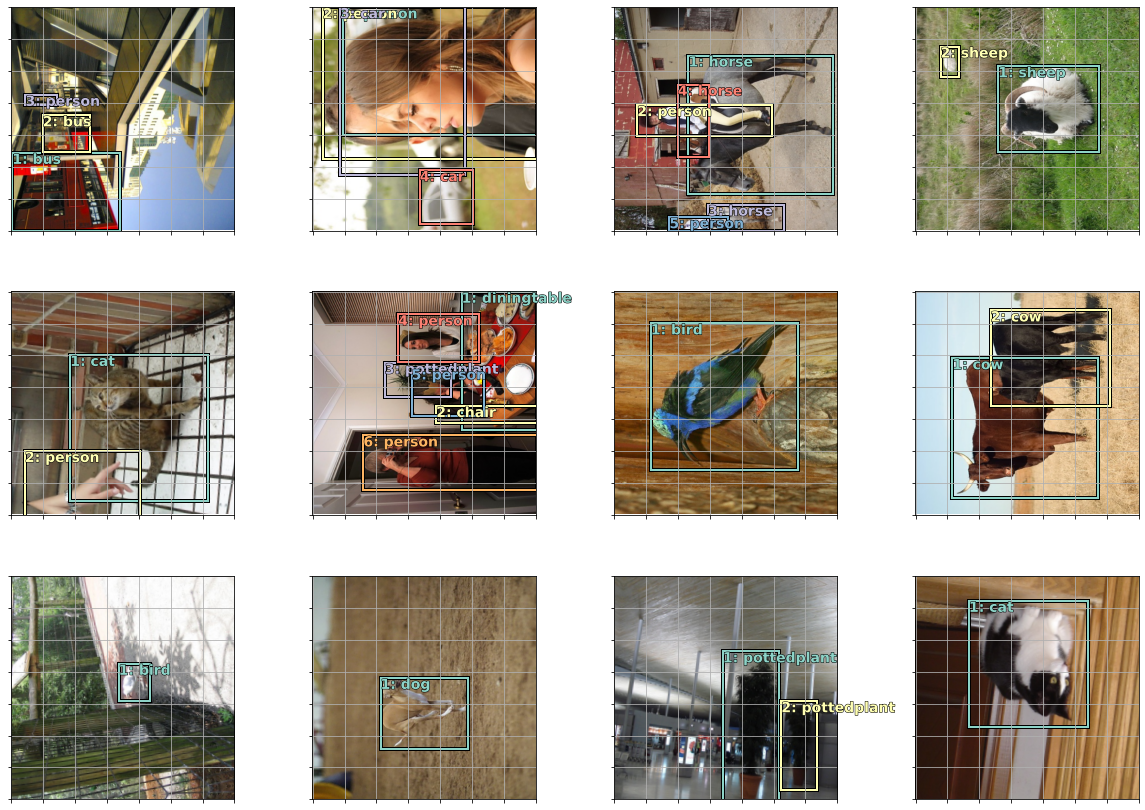

In [54]:
## Bounding Box after dataloader should Rescale
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i].cpu(), ((y[0][i]+1)/2*224).cpu(), y[1][i].cpu())
plt.tight_layout()

Everything looks fine! We have correct bounding boxes and their corresponding classes

## Map to Ground-Truth and Loss function

As you might guess, There are 2 components forming the Object Detection Loss: Classification Loss (For the class) and Localization Loss (For the bounding box)

The idea is, for each image, we will: 
- Calculate the Intersection-over-Union (IoU) of each predefined Anchor Box with the Object Bounding Box. 
- Assign the label for each cell (Map to ground truth) according the IoUs. `Background` will be assigned to Cell which overlap with no object
- Calculate the Classification Loss for all Cells
- Calculate the Bounding Box Location Loss only for Cells responsible to Objects (no Background)
- Take the sum of these 2 losses

!! Notes: Currently, we will loop for each image in a batch to calculate its loss then sum them all. I think we might have a better way to vectorize these operations, or, calculate everything in one shot directly with a batch tensor




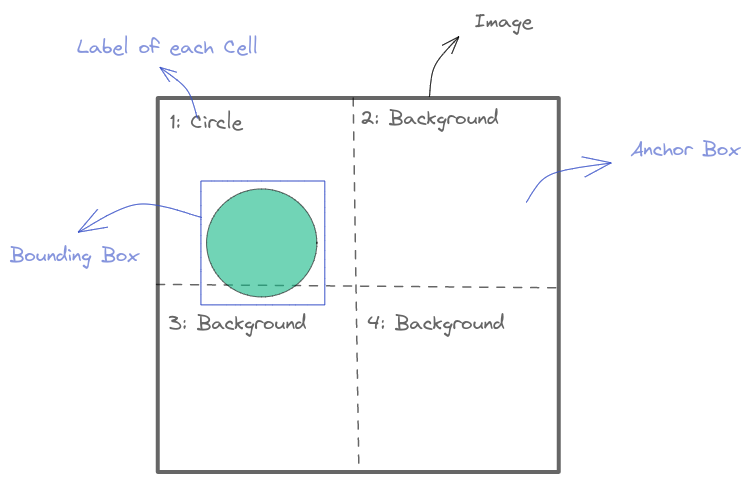

In [55]:
def get_y(bbox,clas):
    """
    Remove the zero batching from a batch
    
    Because the number of object in each image are different so
    we need to zero padding for batching 
    """
    bbox = bbox.view(-1,4)
    clas = clas.view(-1,1)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return TensorBase(bbox)[bb_keep],TensorBase(clas)[bb_keep]

In [56]:
one_batch[2][idx]

TensorMultiCategory([11,  9, 16, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0], device='cuda:0')

In [57]:
get_y(one_batch[1][idx], one_batch[2][idx])

(TensorBBox([[-1.0000,  0.3353,  0.2320,  1.0000],
         [ 0.0240,  0.1078,  0.1720,  1.0000],
         [-0.3640, -0.3533, -0.0680,  0.2275],
         [-0.7960, -0.2335, -0.3800,  0.4790],
         [-0.3120, -0.1138,  0.1040,  0.5269],
         [ 0.2880, -0.5449,  0.7720,  1.0000]], device='cuda:0'),
 TensorBBox([[11],
         [ 9],
         [16],
         [15],
         [15],
         [15]], device='cuda:0'))

We can see that all the zero values is removed before continue to process

In [58]:
def hw2corners(ctr, hw): 
    # Function to convert BB format: (centers and dims) -> corners
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

The Activations are passed to a Tanh function to rescale their values to -1 -> 1. Then they are processed to make coherent with the Grid Coordinates:

- The center of each cell's prediction stays in the cell
- The size of each cell's prediction can be varied from 1/2 to 3/2 cell's size to give more flexibility 


In [59]:
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [60]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels].cuda()

In [61]:
def intersect(box_a, box_b):
    """
    Intersect area between to bounding boxes
    """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

In [62]:
def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

In [63]:
def jaccard(box_a, box_b):
    """
    Jaccard or Intersection over Union
    """
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

`Map to Ground Truth` (Visualization below). The idea is looping through all anchor boxes and calculating the overlaps with the `Ground Truth` bounding boxes, then assigning each Anchor Box to the correspond class

In [64]:
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1) # 3
    gt_overlap, gt_idx = overlaps.max(0) # 16
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

For calculating loss, we will loop through every images in a batch and calculate loss for each image (ssd_1_loss), then summing the result with ssd_loss. The Classification Loss (loss_f) currently is left empty as we will discussion it later in the next section

In [65]:
def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    bbox = (bbox+1)/2
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0  # Assign the background to idx 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((TensorBase(a_ic[TensorBase(pos_idx)]) - TensorBase(gt_bbox[TensorBase(pos_idx)])).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [66]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:]).cuda()

### Showing Map To Ground Truth

As mentionned earlier, Map-to-Ground-Truth is a very important step for calculatating loss. We should show it to make sure everything looks fine

In [67]:
idx = 0
bbox = one_batch[1][idx].cuda()
clas = one_batch[2][idx].cuda()

In [68]:
bbox,clas = get_y(bbox,clas)
bbox = (bbox+1)/2
# a_ic = actn_to_bb(b_bb, anchors)
overlaps = jaccard(bbox.data, anchor_cnr.data)
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_clas = clas[gt_idx]
pos = gt_overlap > 0.4
pos_idx = torch.nonzero(pos)[:,0]
gt_clas[~pos] = 0  # Assign the background to idx 0
gt_bbox = bbox[gt_idx]

In [69]:
ima = one_batch[0][idx].permute(2,1,0).cpu()

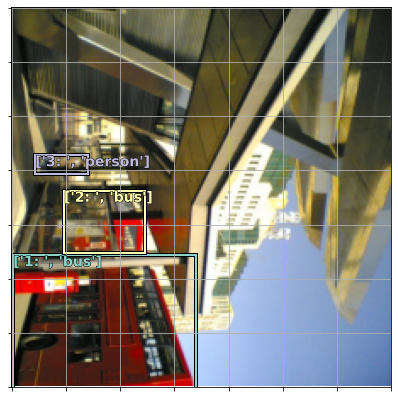

In [70]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

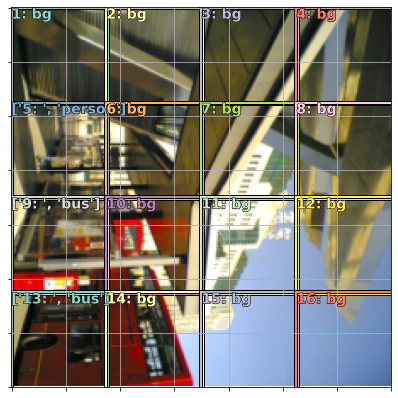

In [71]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, gt_clas)

In [72]:
sz = 224

### Classificaton Loss: Binary Cross Entropy and why Focal Loss

There are 2 tricks can be used for Classification Loss here:

- Binary Cross-Entropy Loss without background
- Further imporve Binary Cross-Entropy Loss with Focal Loss

1. Binary Cross-Entropy

- If we treat the Background Class at one class and ask the Model to understand what is a Background, it might be too difficult. We can translate it to a set of easier questions: Is it a Cat? Is it a Dog? ... through all the classes, which is exactly what Binary Cross-Entropy do


2. Focal Loss

- The classification task in object detection is very imbalance that we have a lot of background object (check the Match to Ground-Truth image above). If we just use Binary Cross-Entropy Loss function, it will try all effort to improve background classification

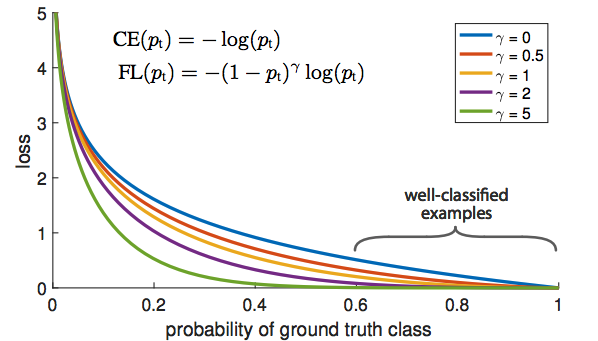

Quote from fastai2018 course:


`The blue line is the binary cross entropy loss. If the answer is not a motorbike, and I said “I think it’s not a motorbike and I am 60% sure” with the blue line, the loss is still about 0.5 which is pretty bad. So if we want to get our loss down, then for all these things which are actually back ground, we have to be saying “I am sure that is background”, “I am sure it’s not a motorbike, or a bus, or a person” — because if I don’t say we are sure it is not any of these things, then we still get loss.`

`That is why the motorbike example did not work. Because even when it gets to lower right corner and it wants to say “I think it’s a motorbike”, there is no payoff for it to say so. If it is wrong, it gets killed. And the vast majority of the time, it is background. Even if it is not background, it is not enough just to say “it’s not background” — you have to say which of the 20 things it is.`

`So the trick is to trying to find a different loss function that looks more like the purple line. Focal loss is literally just a scaled cross entropy loss. Now if we say “I’m .6 sure it’s not a motorbike” then the loss function will say “good for you! no worries”.`

In [73]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ.squeeze(), self.num_classes)
        t = t[:,1:] # Start from 1 to exclude the Background
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w.detach(), reduction='sum')/self.num_classes
    
    def get_weight(self,x,t): return None

In [74]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

The ssd_loss will loop through every images in a batch and accumulate loss 

In [75]:
def ssd_loss(pred, bbox, clas):
    lcs, lls = 0., 0.
    W = 30
    for b_c, b_bb, bbox, clas in zip(*pred, bbox, clas):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas)
        lls += loc_loss
        lcs += clas_loss
    return lls + lcs

In [76]:
loss_f = FocalLoss(len(dls.vocab))

## Training Simple Model

In [77]:
model = nn.Sequential(body, head_reg4)

In [78]:
learner = Learner(dls, model, loss_func=ssd_loss)

In [79]:
learner.fit_one_cycle(5, 1e-3)

The loss decreases, the model can learn something. Looking at the results shown below, we can see that the predictions is not so bad but not particularly good neither. In the next session, we can see how to improve the results with more anchor boxes

### Show Results

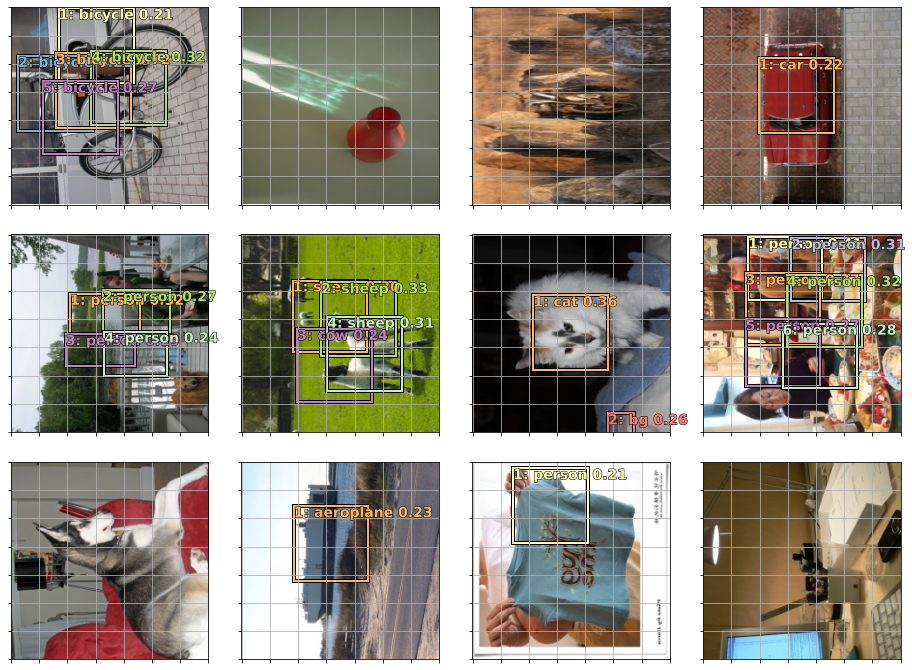

In [80]:
one_batch = dls.valid.one_batch()
learner.model.eval();
pred = learner.model(one_batch[0])
b_clas, b_bb = pred
x = one_batch[0]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima = x.permute(0,3,2,1).cpu()[idx]
#     ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
#plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.15)

## More anchors 

As said earlier, anchor box is a hint for the model to not go too far and focus on a part of the image. So obviously, 4x4 grid is not enough to predict object at any size. In this part, by adding more `Conv2d` layer, we will have 3 grids: 4x4, 2x2, 1x1 and each cell will have 9 variations: 3-zooms and 3-ratios

The total number of anchors is: (16 + 4 + 1) x 9 = 189 anchors

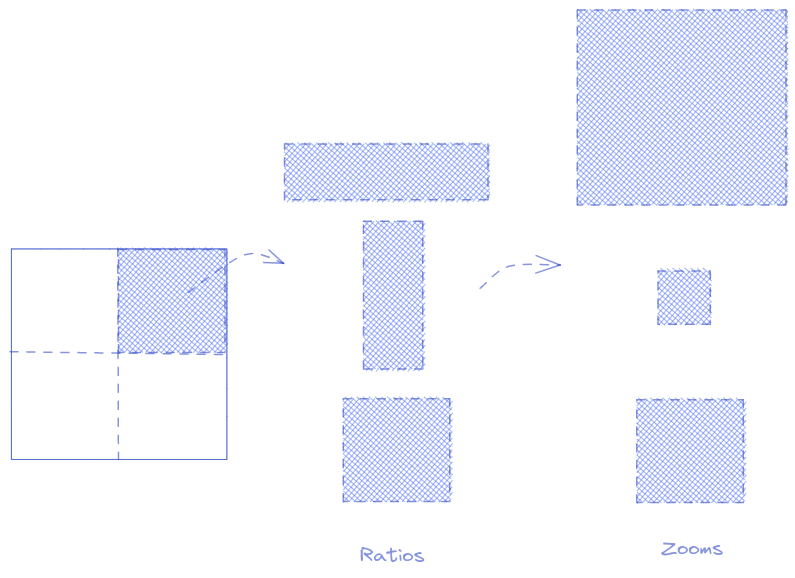

In [81]:
# This is for release the GPU memrory while experimenting. I guess it is not enough. Please tell me if you know a better way
del learner
del model
import gc; gc.collect()
torch.cuda.empty_cache()

In [82]:
anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [83]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [84]:
anc_x

array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625,
       0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875, 0.25 , 0.25 ,
       0.75 , 0.75 , 0.5  ])

In [85]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = torch.tensor(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1).cuda()
anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float().cuda()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:]).cuda()

In [86]:
anchor_cnr.shape

torch.Size([189, 4])

We need to adjust the SSD head a little bit. We will add more `Conv2D` layer with `StdConv` (to create 2x2 and 1x1 grids). After each `StdConv` is a `OutConv` to handle the Classification prediction and Localization prediction

In [87]:
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [88]:
drop=0.4

In [89]:
head_reg4 = SSD_MultiHead(k, -4.)

In [90]:
body = create_body(resnet34(True))
model = nn.Sequential(body, head_reg4)

In [91]:
learner = Learner(dls, model, loss_func=ssd_loss)

In [92]:
# learner.lr_find()

In [93]:
learner.fit_one_cycle(15, 1e-3)

### Show results

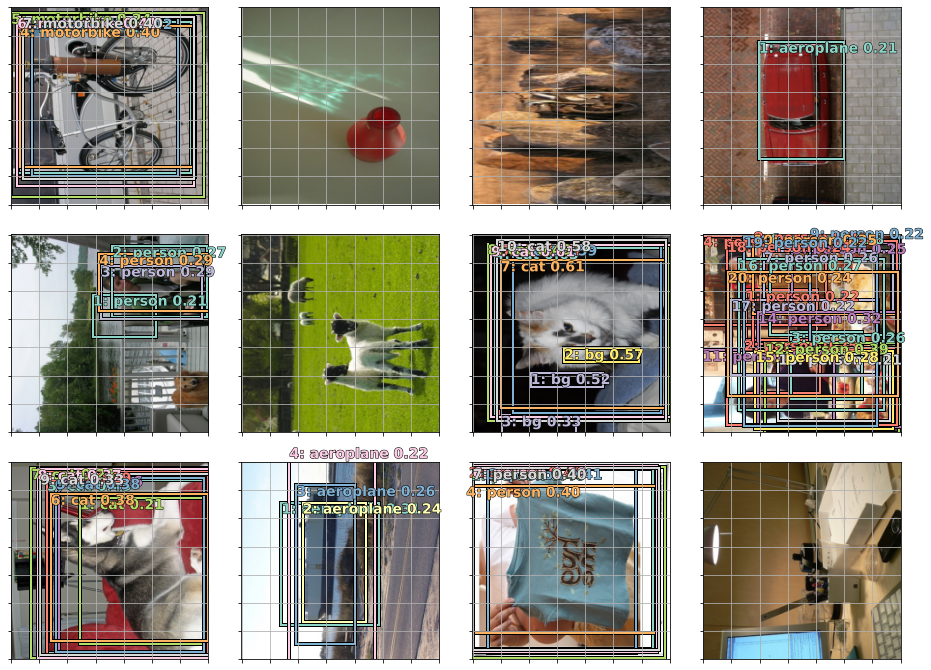

In [94]:
one_batch = dls.valid.one_batch()
learner.model.eval();
pred = learner.model(one_batch[0])
b_clas, b_bb = pred
x = one_batch[0]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima = x.permute(0,3,2,1).cpu()[idx]
#     ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), thresh=0.21)
#plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.15)

## Non Maximum Suppression (NMS)

You can see in the previous results, having a lot of Anchor Boxes leads to have many overlaps. You can use Non Maximum Suppression, a technique to choose one bounding box out of many overlapping ones

In [95]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [96]:
# ima = one_batch[0][idx].permute(2,1,0).cpu()
# bbox = one_batch[1][idx].cuda()
# clas = one_batch[2][idx].cuda()
# bbox,clas = get_y(bbox,clas)

# a_ic = actn_to_bb(b_bb[idx], anchors)
# clas_pr, clas_ids = b_clas[idx].max(1)
# clas_pr = clas_pr.sigmoid()

# conf_scores = b_clas[idx].sigmoid().t().data

# out1,out2,cc = [],[],[]

In [97]:
# conf_scores.shape

In [98]:
def show_nmf(idx):
    ima = one_batch[0][idx].permute(2,1,0).cpu()
    bbox = one_batch[1][idx].cuda()
    clas = one_batch[2][idx].cuda()
    bbox,clas = get_y(bbox,clas)
    
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(1, len(conf_scores)):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if not cc:
        print(f"{i}: empty array")
        return
    cc = torch.tensor(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

1: empty array
2: empty array
3: empty array
5: empty array


/home/ubuntu/.local/lib/python3.8/site-packages/torch/_tensor.py:1142: UserWarning: An output with one or more elements was resized since it had shape [8], which does not match the required output shape [5].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  ret = func(*args, **kwargs)
/home/ubuntu/.local/lib/python3.8/site-packages/torch/_tensor.py:1142: UserWarning: An output with one or more elements was resized since it had shape [5], which does not match the required output shape [1].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/n

11: empty array


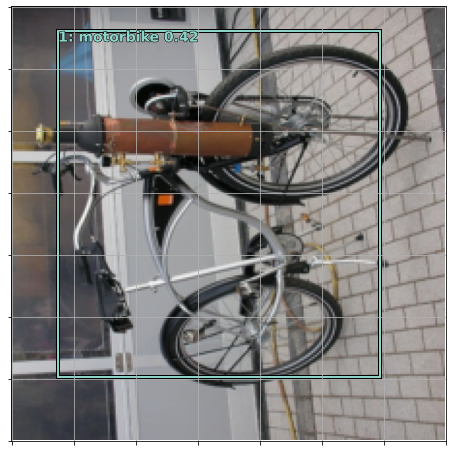

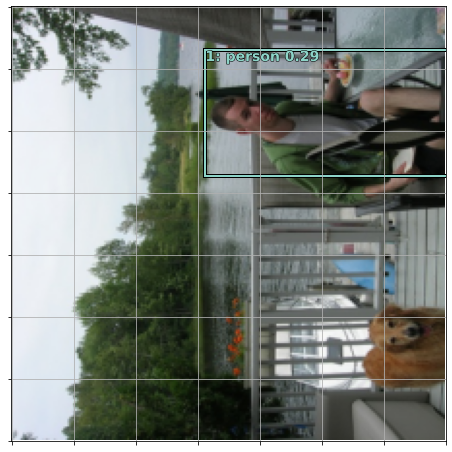

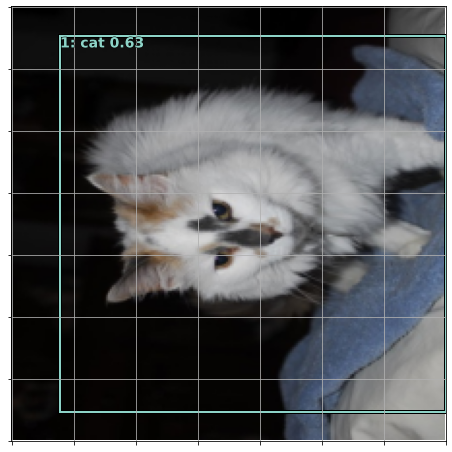

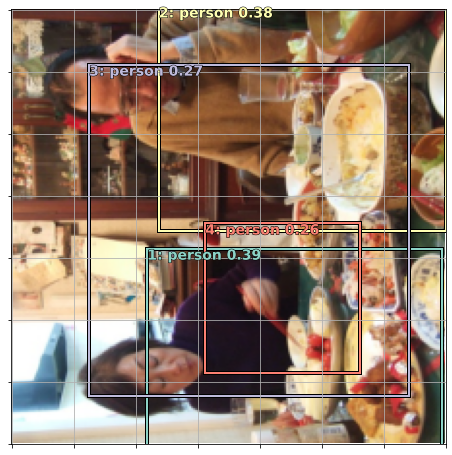

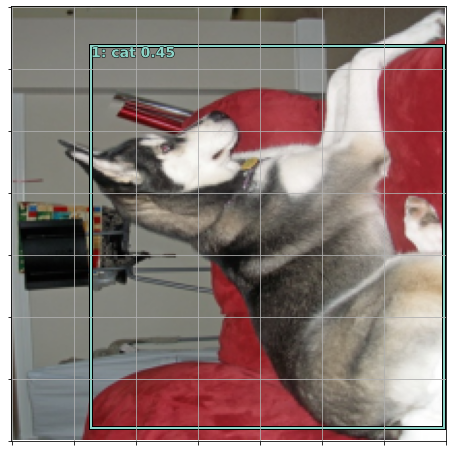

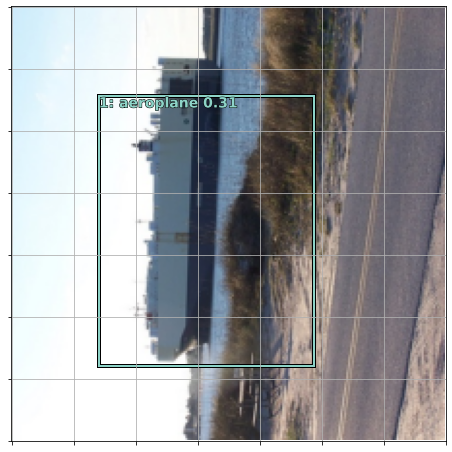

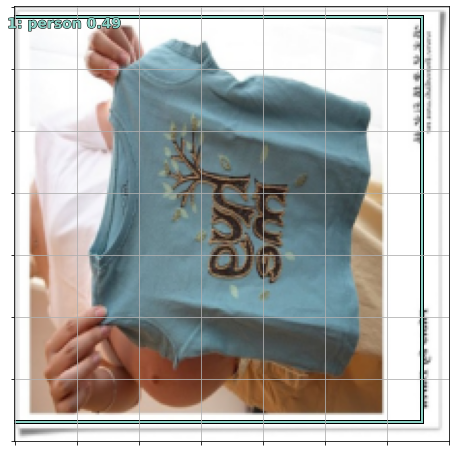

In [99]:
for i in range(12): show_nmf(i)
